## Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
cd /content/drive/My Drive/Applied\ AI\ course\ Assignments/Case\ Study\ 1

/content/drive/My Drive/Applied AI course Assignments/Case Study 1


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import gc
import warnings
warnings.filterwarnings('ignore')

#plt.style.use('dark_background')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#https://www.kaggle.com/fabiendaniel/elo-world
#Function to load data into pandas and reduce memory usage

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

## Loading Files

In [ ]:
historical_transactions = reduce_mem_usage(pd.read_csv('historical_transactions.csv'))

Mem. usage decreased to 1749.11 Mb (43.7% reduction)


In [ ]:
new_merchant_transactions = reduce_mem_usage(pd.read_csv('new_merchant_transactions.csv'))

In [ ]:
merchants = reduce_mem_usage(pd.read_csv('merchants.csv'))

Mem. usage decreased to 30.32 Mb (46.0% reduction)


In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print("Rows and columns in train data: ", train.shape)
print("Rows and columns in test data: ", test.shape)

Rows and columns in train data:  (201917, 6)
Rows and columns in test data:  (123623, 5)


## Data Dictionary files

In [ ]:
data_dictionary_history = pd.read_excel('Data_Dictionary.xlsx', sheet_name='history')
data_dictionary_train = pd.read_excel('Data_Dictionary.xlsx', sheet_name='train')
data_dictionary_merchant = pd.read_excel('Data_Dictionary.xlsx', sheet_name='merchant')
data_dictionary_new_merchant = pd.read_excel('Data_Dictionary.xlsx', sheet_name='new_merchant_period')


## Train file

In [ ]:
data_dictionary_train[2:]

,train.csv,Unnamed: 1
2,card_id,Unique card identifier
3,first_active_month,"'YYYY-MM', month of first purchase"
4,feature_1,Anonymized card categorical feature
5,feature_2,Anonymized card categorical feature
6,feature_3,Anonymized card categorical feature
7,target,Loyalty numerical score calculated 2 months af...


In [ ]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159749


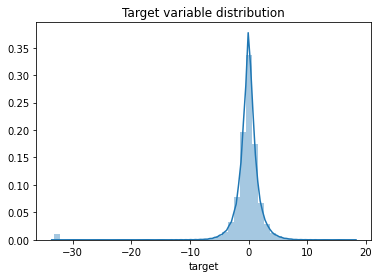

In [ ]:
sns.distplot(train['target'])
plt.title('Target variable distribution')
plt.show()

As we can see there are some points that are far away from all the points which have loyalty scores below -30. Lets analyze these points further

In [ ]:
train_outliers = train[train['target'] < -30]

In [ ]:
perct = train_outliers.shape[0]/train.shape[0]
print("{:3.2f}% of values are these odd points in our train data".format(perct*100))

1.09% of values are these odd points in our train data


Since these odd points constitute to 1% of our data. These are not exactly outliers. These are rare data points.

### Categorical Features

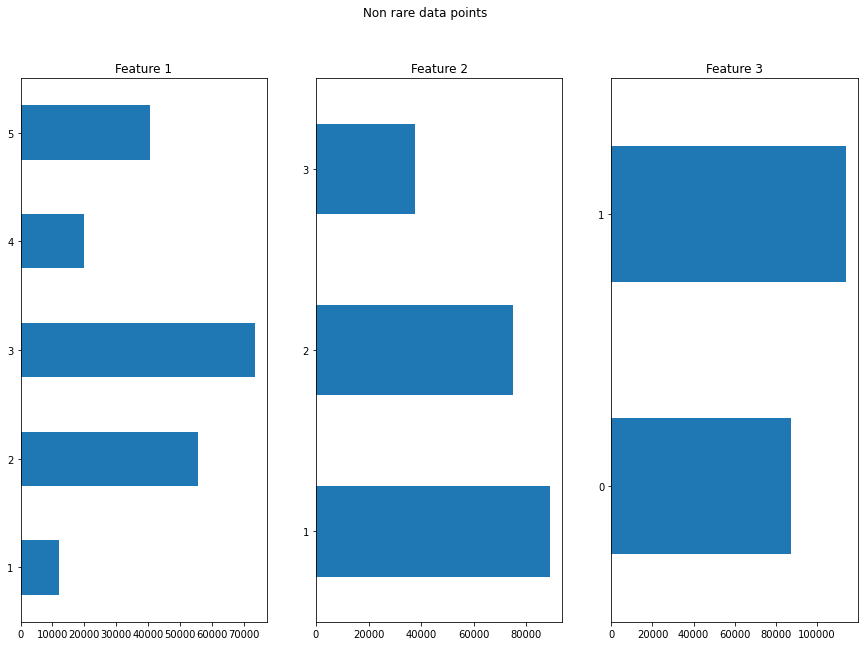

In [ ]:
fig, ax = plt.subplots(1,3, figsize = (15, 10))
train['feature_1'].value_counts().sort_index().plot(kind='barh', title='Feature 1', ax = ax[0])
train['feature_2'].value_counts().sort_index().plot(kind='barh', title='Feature 2', ax = ax[1])
train['feature_3'].value_counts().sort_index().plot(kind='barh', title='Feature 3', ax = ax[2])
plt.suptitle('Non rare data points')
plt.show()

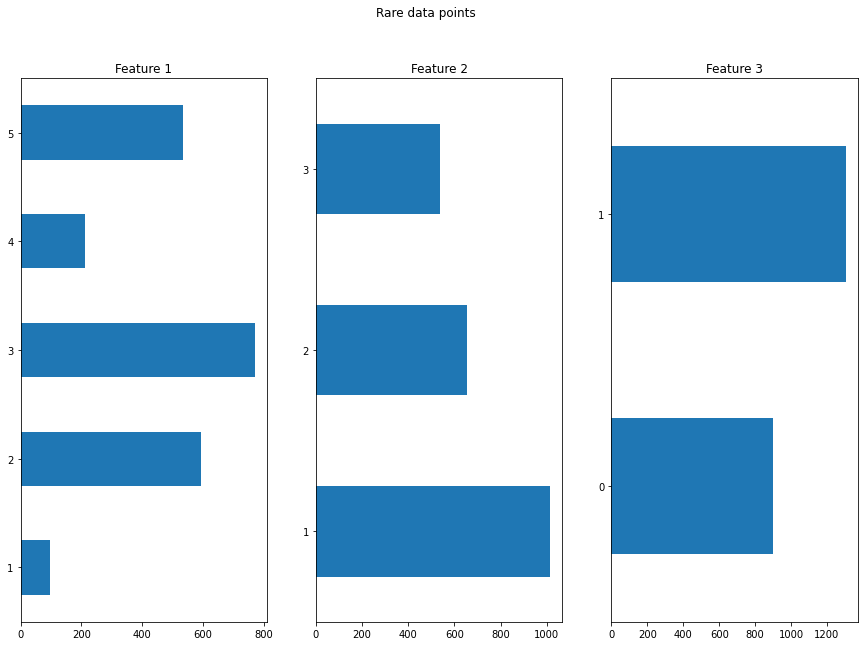

In [ ]:
fig, ax = plt.subplots(1,3, figsize = (15, 10))
train_outliers['feature_1'].value_counts().sort_index().plot(kind='barh', title='Feature 1', ax = ax[0])
train_outliers['feature_2'].value_counts().sort_index().plot(kind='barh', title='Feature 2', ax = ax[1])
train_outliers['feature_3'].value_counts().sort_index().plot(kind='barh', title='Feature 3', ax = ax[2])
plt.suptitle('Rare data points')
plt.show()

There is not much difference between the features 1,2 and 3 for rare and non rare data points. Extracting features from historical transactions and merchant transactions might be helpful to better predict these rare loyalty scores of <-30.

### First Active month

In [ ]:
train['first_active_month'].value_counts()

2017-09    13878
2017-10    13695
2017-08    13638
2017-11    12930
2017-07    12363
           ...  
2012-03       10
2011-11        8
2012-02        7
2011-12        2
2018-02        1
Name: first_active_month, Length: 75, dtype: int64

Converting these date values to months difference from today

In [ ]:
train['first_active_month'] = pd.to_datetime(train['first_active_month'], format='%Y-%M')
today = pd.to_datetime('today')

In [ ]:
train['first_active_month_diff_from_today'] = (12 * (today.year - train['first_active_month'].dt.year) + (today.month - train['first_active_month'].dt.month)) 
train['first_active_month_diff_from_today'].value_counts()

44     130519
56      51277
68      14142
80       4523
92       1129
104       282
32         35
116        10
Name: first_active_month_diff_from_today, dtype: int64

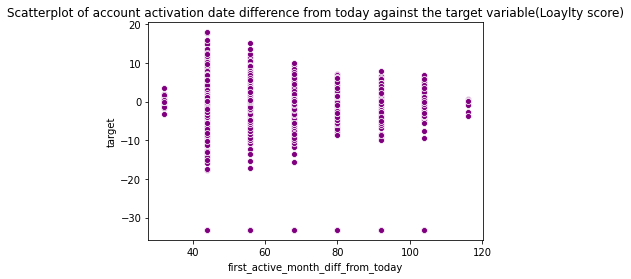

In [ ]:
sns.scatterplot(x=train['first_active_month_diff_from_today'], y=train['target'], color='purple')
plt.title('Scatterplot of account activation date difference from today against the target variable(Loaylty score)')
plt.show()

- We can observe a trend here that the most recent have higher loyalty scores. 
- However, this also shows that there are more number of recent users as compared to long time users.
- One more observation that we can see here is the number of users that have a loyalty score of <=-30 are at the very bottom of the plot for each of the bin/value ranges of the active month difference from today. This shows that this feature might not be useful enough to separate our rare data points from the actual data.
- This feature would definitely help in predicting the loyalty scores.

## Historical Transactions file

In [ ]:
data_dictionary_history[2:]

,historical_transactions.csv,Unnamed: 1
2,card_id,Card identifier
3,month_lag,month lag to reference date
4,purchase_date,Purchase date
5,authorized_flag,"Y' if approved, 'N' if denied"
6,category_3,anonymized category
7,installments,number of installments of purchase
8,category_1,anonymized category
9,merchant_category_id,Merchant category identifier (anonymized )
10,subsector_id,Merchant category group identifier (anonymized )
11,merchant_id,Merchant identifier (anonymized)


In [ ]:
historical_transactions.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


91.355 of all transactions are authorized


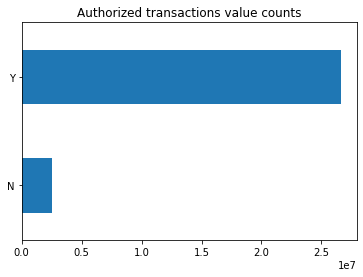

In [ ]:
auth = historical_transactions['authorized_flag'].value_counts()
print("{:3.3f} of all transactions are authorized".format(auth['Y']*100.0/(auth['Y'] + auth['N'])))
historical_transactions['authorized_flag'].value_counts().sort_index().plot(kind='barh', title = 'Authorized transactions value counts')
plt.show()

### Installments

In [ ]:
historical_transactions['installments'].value_counts()

 0      15411747
 1      11677522
 2        666416
 3        538207
 4        179525
-1        178159
 6        132634
 10       118827
 5        116090
 12        55064
 8         20474
 7         10906
 9          5772
 11          830
 999         188
Name: installments, dtype: int64

Values of -1 and 999 seem odd for the installments.

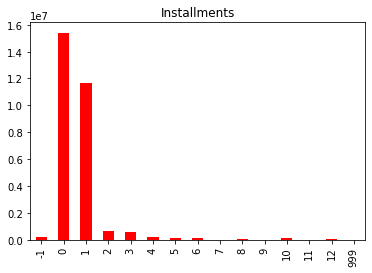

In [ ]:
historical_transactions['installments'].value_counts().sort_index().plot(kind='bar', title= 'Installments', color = 'red')
plt.show()

### Purchase Amounts

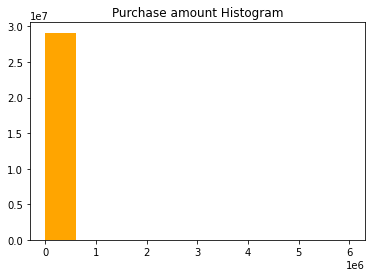

In [ ]:
plt.hist(historical_transactions['purchase_amount'], color='orange')
plt.title('Purchase amount Histogram')
plt.show()

In [ ]:
for i in range(90, 101):
  print("{} percentile value is {:3.3f}".format(i, np.percentile(historical_transactions['purchase_amount'], i)))

90 percentile value is -0.428
91 percentile value is -0.396
92 percentile value is -0.359
93 percentile value is -0.311
94 percentile value is -0.252
95 percentile value is -0.169
96 percentile value is -0.053
97 percentile value is 0.130
98 percentile value is 0.455
99 percentile value is 1.221
100 percentile value is 6010604.000


The 100th percentile value is definitely an outlier. We would have to remove that later.

In [ ]:
historical_transactions['category_1'].value_counts()

N    27028332
Y     2084029
Name: category_1, dtype: int64

In [ ]:
historical_transactions['category_2'].value_counts()

1.0    15177199
3.0     3911795
5.0     3725915
4.0     2618053
2.0     1026535
Name: category_2, dtype: int64

In [ ]:
historical_transactions['category_3'].value_counts()

A    15411747
B    11677522
C     1844933
Name: category_3, dtype: int64

## New merchant transactions

In [ ]:
data_dictionary_new_merchant[2:]

,new_merchant_period.csv,Unnamed: 1
2,card_id,Card identifier
3,month_lag,month lag to reference date
4,purchase_date,Purchase date
5,authorized_flag,"Y' if approved, 'N' if denied"
6,category_3,anonymized category
7,installments,number of installments of purchase
8,category_1,anonymized category
9,merchant_category_id,Merchant category identifier (anonymized )
10,subsector_id,Merchant category group identifier (anonymized )
11,merchant_id,Merchant identifier (anonymized)


In [ ]:
new_merchant_transactions['authorized_flag'].value_counts()

Y    1963031
Name: authorized_flag, dtype: int64

There are no unauthorized transactions in this one.

In [ ]:
new_merchant_transactions['installments'].value_counts()

 0      922244
 1      836178
-1       55922
 2       54729
 3       44750
 4       14815
 6       10389
 5        9296
 10       8899
 12       2850
 8        1555
 7         863
 9         478
 11         61
 999         2
Name: installments, dtype: int64

We can see the same two strange values of -1 and 999 for installments here as well.

### Installments

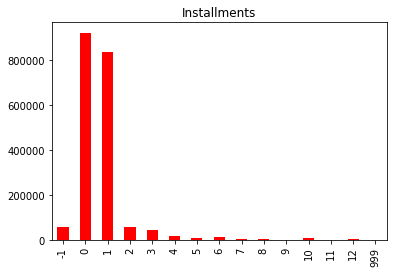

In [ ]:
new_merchant_transactions['installments'].value_counts().sort_index().plot(kind='bar', title= 'Installments', color = 'red')
plt.show()

Most of the installments are in range of -1 and 12.

### Purchase Amounts

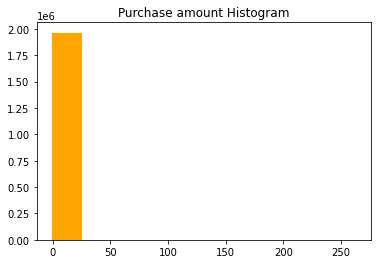

In [ ]:
plt.hist(new_merchant_transactions['purchase_amount'], color='orange')
plt.title('Purchase amount Histogram')
plt.show()

Majority of the purchase amounts are less than 30.

In [ ]:
for i in range(90, 101):
  print("{} percentile value is {:3.3f}".format(i, np.percentile(new_merchant_transactions['purchase_amount'], i)))

90 percentile value is -0.371
91 percentile value is -0.340
92 percentile value is -0.296
93 percentile value is -0.245
94 percentile value is -0.176
95 percentile value is -0.086
96 percentile value is 0.043
97 percentile value is 0.251
98 percentile value is 0.617
99 percentile value is 1.463
100 percentile value is 263.250


The 100th percentile value is 263.250. This maybe an outlier as it is very far from all other values. 

### One hot encoding categorical variables

In [ ]:
new_merchant_transactions = pd.get_dummies(new_merchant_transactions, columns=['category_1', 'category_2', 'category_3'])
historical_transactions = pd.get_dummies(historical_transactions, columns=['category_1', 'category_2', 'category_3'])

### Combining with train dataframe

In [ ]:
grouped_transactions_1 = new_merchant_transactions.groupby('card_id')[['installments', 'purchase_amount', 'category_1_N', 'category_1_N',	'category_1_Y',	'category_2_1.0',	'category_2_2.0',	'category_2_3.0',	'category_2_4.0',	'category_2_5.0',	'category_3_A',	'category_3_B','category_3_C']].sum()
grouped_transactions_2 = historical_transactions.groupby('card_id')[['installments', 'purchase_amount', 'category_1_N', 'category_1_N',	'category_1_Y',	'category_2_1.0',	'category_2_2.0',	'category_2_3.0',	'category_2_4.0',	'category_2_5.0',	'category_3_A',	'category_3_B','category_3_C']].sum()

In [ ]:
grouped_transactions_1.head()

,installments,purchase_amount,category_1_N,category_1_N,category_1_Y,category_2_1.0,category_2_2.0,category_2_3.0,category_2_4.0,category_2_5.0,category_3_A,category_3_B,category_3_C
card_id,,,,,,,,,,,,,
C_ID_00007093c1,2,-1.328125,2,2,0,1,0,1,0,0,0,2,0
C_ID_0001238066,42,-14.851562,24,24,2,20,0,0,0,3,0,21,4
C_ID_0001506ef0,0,-1.447266,2,2,0,0,0,2,0,0,2,0,0
C_ID_0001793786,0,-0.229004,31,31,0,15,8,5,0,1,31,0,0
C_ID_000183fdda,16,-6.589844,11,11,0,0,0,11,0,0,0,6,4


Removing the duplicated columns

In [ ]:
grouped_transactions_1 = grouped_transactions_1.loc[:,~grouped_transactions_1.columns.duplicated()]
grouped_transactions_2 = grouped_transactions_2.loc[:,~grouped_transactions_2.columns.duplicated()]

In [ ]:
grouped_transactions_1 = grouped_transactions_1.reset_index()
grouped_transactions_2 = grouped_transactions_2.reset_index()

In [ ]:
print(len(grouped_transactions_1.index.values)) 
print(len(grouped_transactions_2.index.values))

290001
325540


We have some extra cards in the second dataframe.

In [ ]:
from tqdm.autonotebook import tqdm

for i in tqdm(range(len(grouped_transactions_1['card_id']))):
  grouped_transactions_2['installments'][i] = grouped_transactions_2['installments'][i] + grouped_transactions_1['installments'][i]
  grouped_transactions_2['purchase_amount'][i] = grouped_transactions_2['purchase_amount'][i] + grouped_transactions_1['purchase_amount'][i]
  grouped_transactions_2['category_1_N'][i] = grouped_transactions_2['category_1_N'][i] + grouped_transactions_1['category_1_N'][i]
  grouped_transactions_2['category_1_Y'][i] = grouped_transactions_2['category_1_Y'][i] + grouped_transactions_1['category_1_Y'][i]
  grouped_transactions_2['category_2_1.0'][i] = grouped_transactions_2['category_2_1.0'][i] + grouped_transactions_1['category_2_1.0'][i]
  grouped_transactions_2['category_2_2.0'][i] = grouped_transactions_2['category_2_2.0'][i] + grouped_transactions_1['category_2_2.0'][i]
  grouped_transactions_2['category_2_3.0'][i] = grouped_transactions_2['category_2_3.0'][i] + grouped_transactions_1['category_2_3.0'][i]
  grouped_transactions_2['category_2_4.0'][i] = grouped_transactions_2['category_2_4.0'][i] + grouped_transactions_1['category_2_4.0'][i]
  grouped_transactions_2['category_2_5.0'][i] = grouped_transactions_2['category_2_5.0'][i] + grouped_transactions_1['category_2_5.0'][i]
  grouped_transactions_2['category_3_A'][i] = grouped_transactions_2['category_3_A'][i] + grouped_transactions_1['category_3_A'][i]
  grouped_transactions_2['category_3_B'][i] = grouped_transactions_2['category_3_B'][i] + grouped_transactions_1['category_3_B'][i] 
  grouped_transactions_2['category_3_C'][i] = grouped_transactions_2['category_3_C'][i] + grouped_transactions_1['category_3_C'][i] 

In [ ]:
len(train['card_id'])

201917

In [ ]:
train_aggregated = pd.merge(train, grouped_transactions_2, on='card_id', how='left')
train_aggregated.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,first_active_month_diff_from_today,installments,purchase_amount,category_1_N,category_1_Y,category_2_1.0,category_2_2.0,category_2_3.0,category_2_4.0,category_2_5.0,category_3_A,category_3_B,category_3_C
0,2017-01-01 00:06:00,C_ID_92a2005557,5,2,1,-0.820283,44,9,-169.234360,265.0,0.0,258.0,0.0,0.0,4.0,3.0,256.0,9.0,0.0
1,2017-01-01 00:01:00,C_ID_3d0044924f,4,1,0,0.392913,44,543,-210.906723,321.0,31.0,319.0,0.0,0.0,0.0,2.0,2.0,276.0,72.0
2,2016-01-01 00:08:00,C_ID_d639edf6cd,2,2,0,0.688056,56,8,-33.815826,50.0,0.0,5.0,0.0,0.0,0.0,45.0,43.0,6.0,1.0
3,2017-01-01 00:09:00,C_ID_186d6a6901,4,3,0,0.142495,44,85,-50.163239,66.0,12.0,12.0,0.0,0.0,53.0,0.0,0.0,69.0,7.0
4,2017-01-01 00:11:00,C_ID_cdbd2c0db2,1,3,0,-0.159749,44,183,-49.419590,119.0,15.0,11.0,0.0,0.0,107.0,1.0,0.0,127.0,7.0


In [ ]:
train_aggregated.to_csv('train_aggregated.csv')

In [ ]:
# to load the CSV file directly
#train_aggregated = pd.read_csv('train_aggregated.csv')

#### Now lets plot and check installments and purchase_amount

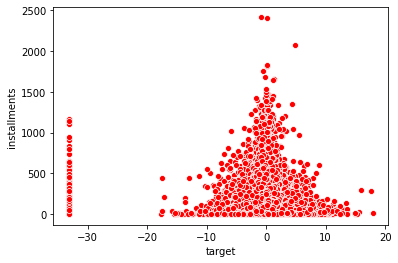

In [ ]:
sns.scatterplot(x=train_aggregated['target'], y=train_aggregated['installments'], color='red')
plt.show()

As the target score seems to be standardized(in some range), the people with higher number of installments are observed to have a loyalty score that is closer to zero. 

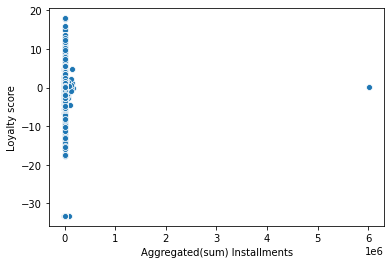

In [ ]:
sns.scatterplot(y=train_aggregated['target'], x=train_aggregated['purchase_amount'])
plt.ylabel('Loyalty score')
plt.xlabel('Aggregated(sum) Installments')
plt.show()

Cant infer anything from the above plot.

#### Ploting the sum of transaction amounts against the loyalty score

In [ ]:
#https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-elo

gdf = historical_transactions.groupby("card_id")
gdf = gdf["purchase_amount"].agg(['sum', 'mean', 'std', 'min', 'max']).reset_index()
gdf.columns = ["card_id", "sum_hist_trans", "mean_hist_trans", "std_hist_trans", "min_hist_trans", "max_hist_trans"]
train_df = pd.merge(train, gdf, on="card_id", how="left")

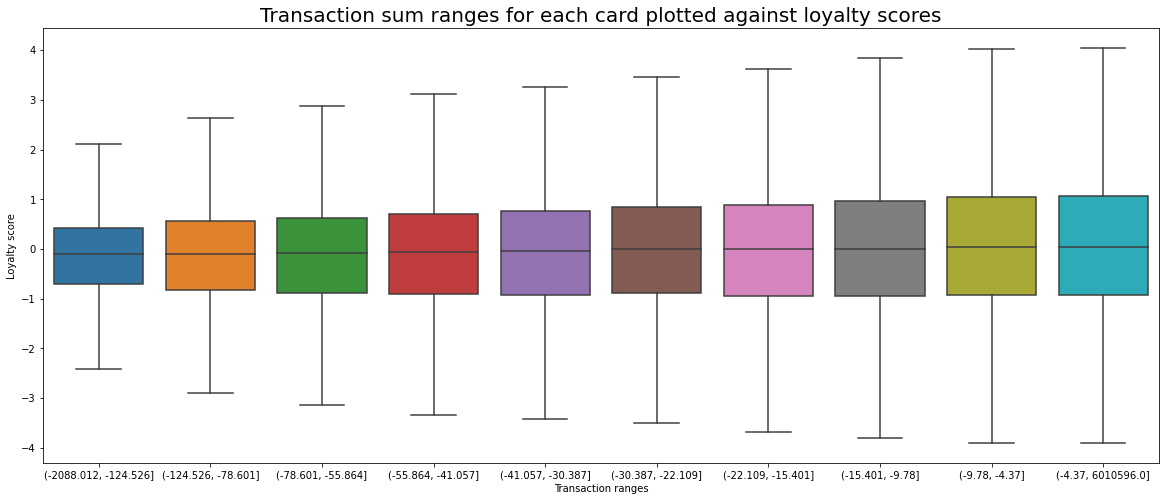

In [ ]:
bins = np.percentile(train_df["sum_hist_trans"], range(0,101,10))
train_df['binned_sum_hist_trans'] = pd.cut(train_df['sum_hist_trans'], bins)

plt.figure(figsize=(20,8))
sns.boxplot(x="binned_sum_hist_trans", y=train_df['target'], data=train_df, showfliers=False)
#plt.xticks(rotation='vertical')
plt.xlabel('Transaction ranges')
plt.ylabel('Loyalty score')
plt.title("Transaction sum ranges for each card plotted against loyalty scores", fontsize = 20)
plt.show()

As we can see here that the loyalty score increases with the increase in sum of transaction values.

## Merchants data

In [ ]:
data_dictionary_merchant[2:]

,merchants.csv,Unnamed: 1
2,merchant_id,Unique merchant identifier
3,merchant_group_id,Merchant group (anonymized )
4,merchant_category_id,Unique identifier for merchant category (anony...
5,subsector_id,Merchant category group (anonymized )
6,numerical_1,anonymized measure
7,numerical_2,anonymized measure
8,category_1,anonymized category
9,most_recent_sales_range,Range of revenue (monetary units) in last acti...
10,most_recent_purchases_range,Range of quantity of transactions in last acti...
11,avg_sales_lag3,Monthly average of revenue in last 3 months di...


### Anonymized Categories

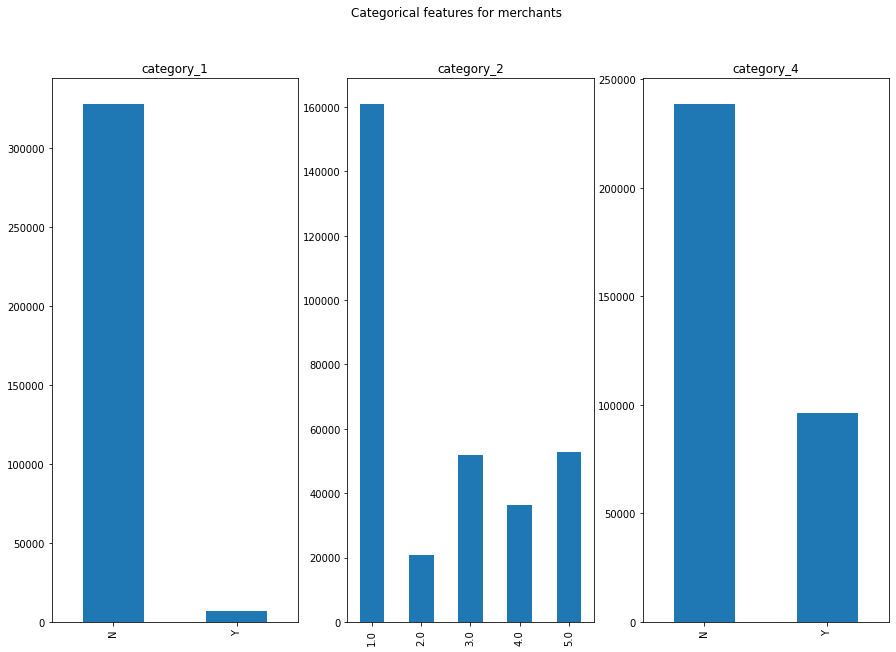

In [ ]:
fig, ax = plt.subplots(1,3, figsize = (15, 10))

merchants['category_1'].value_counts().sort_index().plot(kind='bar', title="category_1", ax=ax[0])
merchants['category_2'].value_counts().sort_index().plot(kind='bar', title="category_2", ax=ax[1])
merchants['category_4'].value_counts().sort_index().plot(kind='bar', title="category_4", ax=ax[2])
plt.suptitle("Categorical features for merchants")
plt.show()


Since all three features are anonymized, we cant say much about the merchants from these plots even though much can be interpreted from the plots.

However, it can be further explored and checked if the merchants involved in a transaction belongs to the majority category then what possible loyalty score could it lead to.

### Anonymized numerical measures

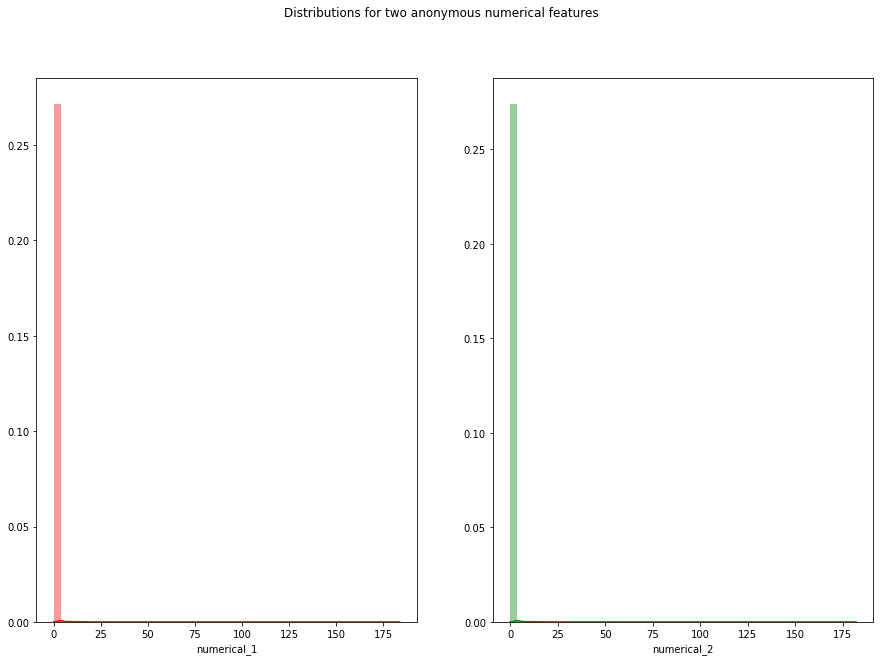

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (15, 10))
sns.distplot(merchants['numerical_1'], ax=ax[0], color='red')
sns.distplot(merchants['numerical_2'], ax=ax[1], color='green')
plt.suptitle('Distributions for two anonymous numerical features')
plt.show()

Cant interpret much from this.

In [ ]:
merchants['most_recent_sales_range'].value_counts()

E    177104
D    117475
C     34075
B      5037
A      1005
Name: most_recent_sales_range, dtype: int64

Most recent sales range for majority of the merchants is E(which is the lowest)

In [ ]:
merchants['most_recent_purchases_range'].value_counts()

E    175309
D    119187
C     34144
B      5046
A      1010
Name: most_recent_purchases_range, dtype: int64

Purchase range follows the same trend as well.

### Active months for each merchant

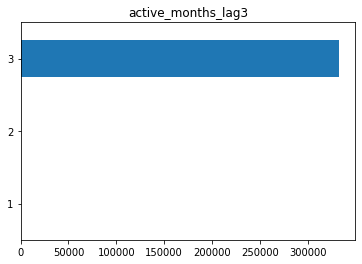

3    333262
2       896
1       538
Name: active_months_lag3, dtype: int64


In [ ]:
merchants['active_months_lag3'].value_counts().sort_index().plot(kind='barh', title="active_months_lag3")
plt.show()
print(merchants['active_months_lag3'].value_counts())

So 99.580% of merchants are active in all of the last 3 months(from the reference date). <br>
This can be used further as there might be a possibility that transactions with less active(or previously active) merchants might give the card a low loyalty score.

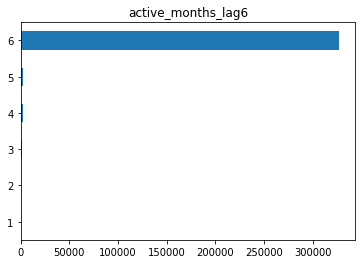

6    327284
5      2276
4      2050
3      1652
2       896
1       538
Name: active_months_lag6, dtype: int64


In [ ]:
merchants['active_months_lag6'].value_counts().sort_index().plot(kind='barh', title="active_months_lag6")
plt.show()
print(merchants['active_months_lag6'].value_counts())

We can observe more that are not active merchants for all of the last 6 months as compared to the last 3.

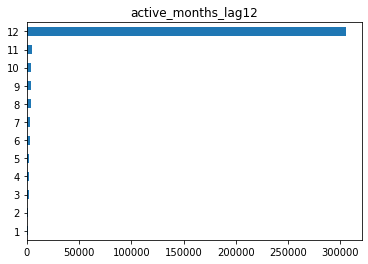

12    305101
11      4449
10      4143
9       3824
8       3756
7       3274
6       2737
5       2276
4       2050
3       1652
2        896
1        538
Name: active_months_lag12, dtype: int64


In [ ]:
merchants['active_months_lag12'].value_counts().sort_index().plot(kind='barh', title="active_months_lag12")
plt.show()
print(merchants['active_months_lag12'].value_counts())

This gives us a very fair idea of all the merchants that are active throughout the year. <br>
As seen 90.115% of merchants are active thorugh out the year.<br>
This can be used to filter out transactions that were old or with merchants that are inactive now. So there might be a possibility that cards with transactions from these merchants would have a low loyalty score.

### Combining with transactions and train data

In [ ]:
merchants = merchants[['merchant_id', 'most_recent_sales_range', 'most_recent_purchases_range', 'active_months_lag3', 'active_months_lag6', 'active_months_lag12']]
historical_transactions = historical_transactions[['card_id', 'merchant_id']]
new_merchant_transactions = new_merchant_transactions[['card_id', 'merchant_id']]

Now let's combine these columns with our train data and plot them against loyalty scores to see how useful these active months columns are.

In [ ]:
historical_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29112361 entries, 0 to 29112360
Data columns (total 2 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   card_id      object
 1   merchant_id  object
dtypes: object(2)
memory usage: 444.2+ MB


In [ ]:
new_merchant_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1963031 entries, 0 to 1963030
Data columns (total 2 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   card_id      object
 1   merchant_id  object
dtypes: object(2)
memory usage: 30.0+ MB


In [ ]:
historical_transactions = historical_transactions.append(new_merchant_transactions, ignore_index=True)
historical_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31075392 entries, 0 to 31075391
Data columns (total 2 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   card_id      object
 1   merchant_id  object
dtypes: object(2)
memory usage: 474.2+ MB


In [ ]:
merged_transactions = pd.merge(historical_transactions, merchants, on='merchant_id', how='left')
merged_transactions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32328675 entries, 0 to 32328674
Data columns (total 7 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   card_id                      object 
 1   merchant_id                  object 
 2   most_recent_sales_range      object 
 3   most_recent_purchases_range  object 
 4   active_months_lag3           float64
 5   active_months_lag6           float64
 6   active_months_lag12          float64
dtypes: float64(3), object(4)
memory usage: 1.9+ GB


In [ ]:
merged_transactions.to_csv('merged_transactions_with_merchants.csv')

In [ ]:
#Load the merged trasactions if needed
merged_transactions = pd.read_csv('merged_transactions_with_merchants.csv')

Now grouping these based on card_id and taking the mean of active_months_lag and mode for most recent sales and purchase range 

In [ ]:
merged_transactions_1 = merged_transactions.groupby('card_id', as_index=False)[['active_months_lag3', 'active_months_lag6', 'active_months_lag12']].mean().round(0) 

In [ ]:
merged_transactions_2 = merged_transactions.groupby('card_id', as_index=False)[['most_recent_sales_range', 'most_recent_purchases_range']].agg(lambda x: pd.Series.mode(x)[0]) 

In [ ]:
train_aggregated_2 = pd.merge(train, merged_transactions_1, on='card_id', how= 'left')
train_aggregated_2 = pd.merge(train_aggregated_2, merged_transactions_2, on='card_id', how= 'left')
train_aggregated_2.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,active_months_lag3,active_months_lag6,active_months_lag12,most_recent_sales_range,most_recent_purchases_range
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283,3.0,6.0,12.0,C,A
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913,3.0,6.0,12.0,A,A
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056,3.0,6.0,12.0,A,A
3,2017-09,C_ID_186d6a6901,4,3,0,0.142495,3.0,6.0,11.0,A,A
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159749,3.0,6.0,12.0,D,D


In [ ]:
train_aggregated_2.to_csv('train_aggregated_2.csv')

In [ ]:
#Read the csv file if needed
train_aggregated_2 = pd.read_csv('train_aggregated_2.csv')

#### Plotting the active months against the target variable(loyalty score)

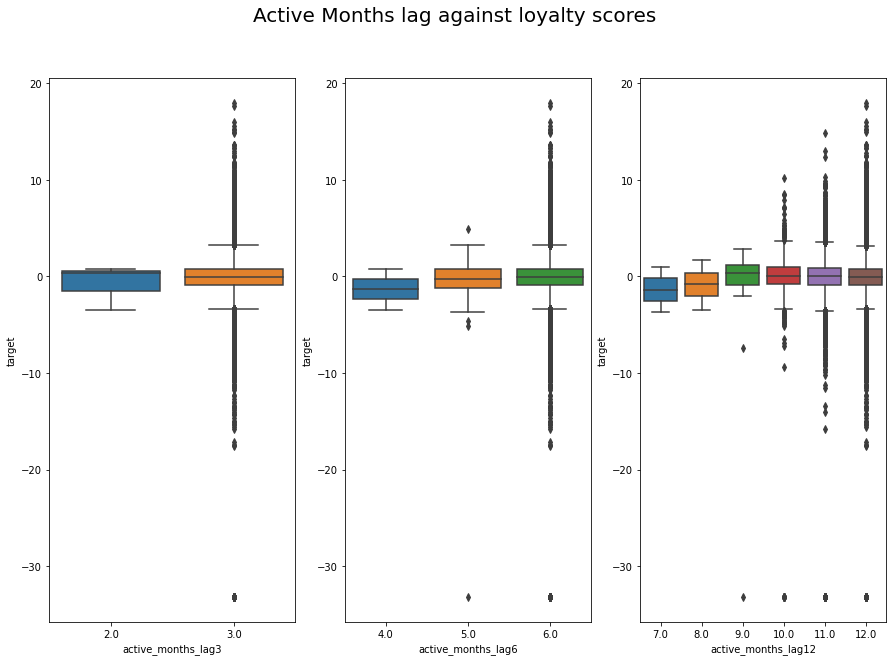

In [ ]:
fig, ax = plt.subplots(1,3, figsize = (15,10))
sns.boxplot(x=train_aggregated_2['active_months_lag3'], y=train_aggregated_2['target'], ax = ax[0])
sns.boxplot(x=train_aggregated_2['active_months_lag6'], y=train_aggregated_2['target'], ax = ax[1])
sns.boxplot(x=train_aggregated_2['active_months_lag12'], y=train_aggregated_2['target'], ax = ax[2])
plt.suptitle('Active Months lag against loyalty scores', fontsize = 20)
plt.show()

As we can observe here, the cards with less number of active months have a low loyalty score. 
<br>
We can see a lot of variance here. These active months columns might be useful as features.

#### Plotting the purchases and sales range against the loyalty score

In [ ]:
train_aggregated_2['most_recent_sales_range'].value_counts()

A    91036
C    53555
B    28396
D    24260
E     4670
Name: most_recent_sales_range, dtype: int64

In [ ]:
train_aggregated_2.head()

,Unnamed: 0,first_active_month,card_id,feature_1,feature_2,feature_3,target,active_months_lag3,active_months_lag6,active_months_lag12,most_recent_sales_range,most_recent_purchases_range
0,0,2017-06,C_ID_92a2005557,5,2,1,-0.820283,3.0,6.0,12.0,C,A
1,1,2017-01,C_ID_3d0044924f,4,1,0,0.392913,3.0,6.0,12.0,A,A
2,2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056,3.0,6.0,12.0,A,A
3,3,2017-09,C_ID_186d6a6901,4,3,0,0.142495,3.0,6.0,11.0,A,A
4,4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159749,3.0,6.0,12.0,D,D


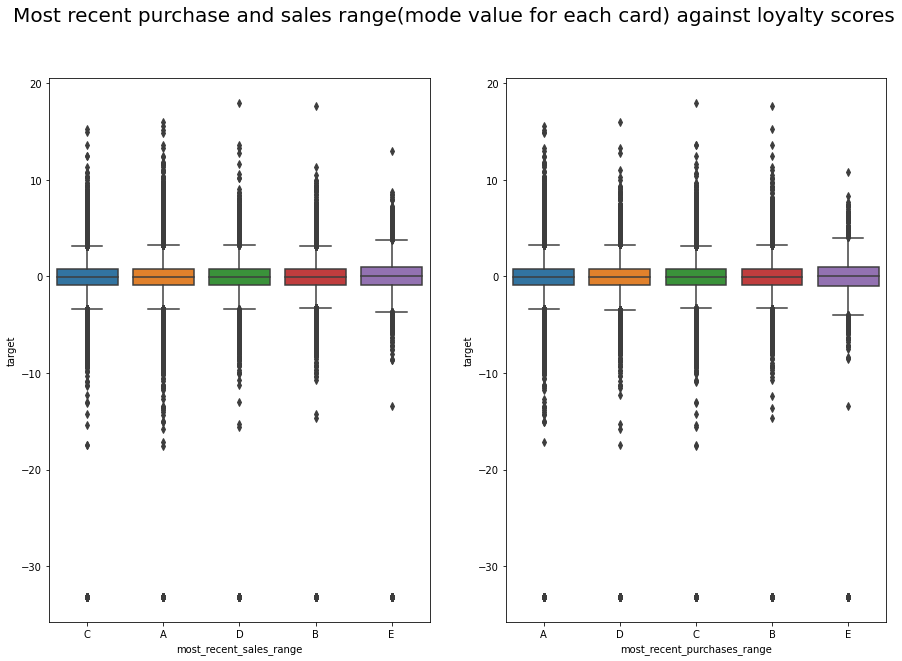

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (15,10))
sns.boxplot(x=train_aggregated_2['most_recent_sales_range'], y=train_aggregated_2['target'], ax = ax[0])
sns.boxplot(x=train_aggregated_2['most_recent_purchases_range'], y=train_aggregated_2['target'], ax = ax[1])
plt.suptitle('Most recent purchase and sales range(mode value for each card) against loyalty scores', fontsize = 20)
plt.show()

There isnt much that we can infer from here. 
<br>
Still, these might be useful for the models.
<br>
Even here, we can see the rare data points evenly spaced at the bottom. 

### Average Purchase and Sales numerical measures

In [ ]:
merchants.shape

(334696, 22)

In [ ]:
merchants['avg_sales_lag3'].isna().sum()

13

So we have just 13 values that have Nan values.
<br>
We can fill these with mean value.
<br>
We can do the same for other sales and purchase avg columns as well.

In [ ]:
merchants['avg_sales_lag3'] = merchants['avg_sales_lag3'].fillna(merchants['avg_sales_lag3'].mean())
merchants['avg_sales_lag6'] = merchants['avg_sales_lag6'].fillna(merchants['avg_sales_lag6'].mean())
merchants['avg_sales_lag12'] = merchants['avg_sales_lag12'].fillna(merchants['avg_sales_lag12'].mean())
merchants['avg_purchases_lag3'] = merchants['avg_purchases_lag3'].fillna(merchants['avg_purchases_lag3'].mean())
merchants['avg_purchases_lag6'] = merchants['avg_purchases_lag6'].fillna(merchants['avg_purchases_lag6'].mean())
merchants['avg_purchases_lag12'] = merchants['avg_purchases_lag12'].fillna(merchants['avg_purchases_lag12'].mean())

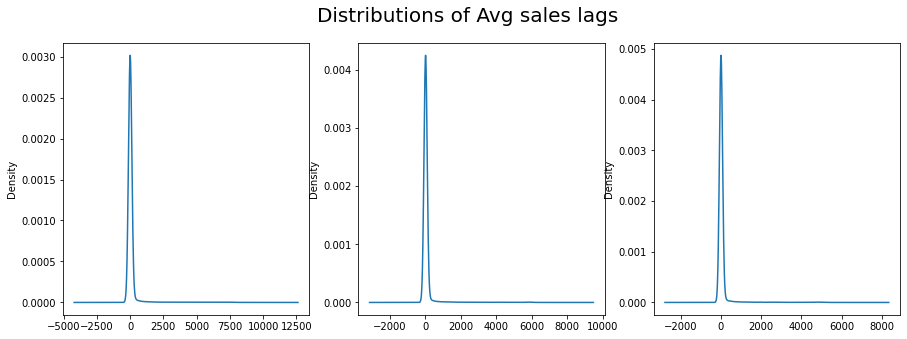

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(15, 5))
merchants['avg_sales_lag3'].value_counts().sort_index().plot(kind='kde', ax=ax[0])
merchants['avg_sales_lag6'].value_counts().sort_index().plot(kind='kde', ax=ax[1])
merchants['avg_sales_lag12'].value_counts().sort_index().plot(kind='kde', ax=ax[2])
plt.suptitle('Distributions of Avg sales lags', fontsize=20)
plt.show()

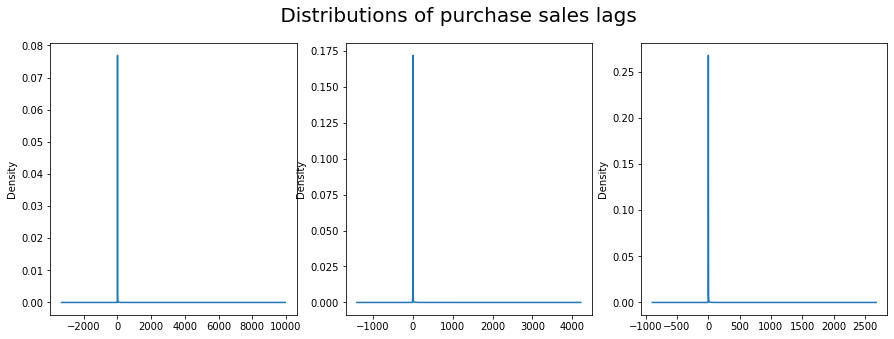

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(15, 5))
merchants['avg_purchases_lag3'].value_counts().sort_index().plot(kind='kde', ax=ax[0])
merchants['avg_purchases_lag6'].value_counts().sort_index().plot(kind='kde', ax=ax[1])
merchants['avg_purchases_lag12'].value_counts().sort_index().plot(kind='kde', ax=ax[2])
plt.suptitle(' Distributions of purchase sales lags', fontsize=20)
plt.show()

As observed all these sales ranges have most of the values around 0.

#### Combining with the transactions and train dataframe

In [ ]:
merged_transactions.head()

,Unnamed: 0,card_id,merchant_id,most_recent_sales_range,most_recent_purchases_range,active_months_lag3,active_months_lag6,active_months_lag12
0,0,C_ID_4e6213e9bc,M_ID_e020e9b302,A,A,3.0,6.0,12.0
1,1,C_ID_4e6213e9bc,M_ID_86ec983688,A,A,3.0,6.0,12.0
2,2,C_ID_4e6213e9bc,M_ID_979ed661fc,C,C,3.0,6.0,12.0
3,3,C_ID_4e6213e9bc,M_ID_e6d5ae8ea6,D,C,3.0,6.0,12.0
4,4,C_ID_4e6213e9bc,M_ID_e020e9b302,A,A,3.0,6.0,12.0


In [ ]:
merged_merchants.head()

,avg_sales_lag3,avg_sales_lag6,avg_sales_lag12,avg_purchases_lag3,avg_purchases_lag6,avg_purchases_lag12
merchant_id,,,,,,
M_ID_000025127f,1.29,1.26,1.08,1.880342,2.228632,2.089744
M_ID_0000699140,0.99,1.04,1.24,0.997832,1.002168,1.154878
M_ID_00006a5552,1.21,1.18,1.22,1.000000,1.000000,1.035714
M_ID_000087311e,0.93,0.95,0.78,1.314815,1.300926,1.261574
M_ID_0000ab0b2d,1.05,0.99,1.06,1.089897,1.057279,1.135640


In [ ]:
merchants[['merchant_id', 'avg_sales_lag3']]

,merchant_id,avg_sales_lag3
0,M_ID_838061e48c,-0.400000
1,M_ID_9339d880ad,-0.720000
2,M_ID_e726bbae1e,-82.129997
3,M_ID_a70e9c5f81,13.839176
4,M_ID_64456c37ce,13.839176
...,...,...
334691,M_ID_1f4773aa76,1.000000
334692,M_ID_725a60d404,0.890000
334693,M_ID_f2045dd267,0.960000
334694,M_ID_9139332ccc,0.940000


In [ ]:
merged_transactions = pd.merge(merged_transactions, \
                               merchants[['merchant_id', 'avg_sales_lag3', \
                                          'avg_sales_lag6', 'avg_sales_lag12', \
                                          'avg_purchases_lag3', 'avg_purchases_lag6', \
                                          'avg_purchases_lag12']], on='merchant_id', how='left')

In [ ]:
merged_transactions.head()

,Unnamed: 0,card_id,merchant_id,most_recent_sales_range,most_recent_purchases_range,active_months_lag3,active_months_lag6,active_months_lag12,avg_sales_lag3,avg_sales_lag6,avg_sales_lag12,avg_purchases_lag3,avg_purchases_lag6,avg_purchases_lag12
0,0,C_ID_4e6213e9bc,M_ID_e020e9b302,A,A,3.0,6.0,12.0,1.08,1.14,1.19,1.082451,1.114135,1.156844
1,1,C_ID_4e6213e9bc,M_ID_86ec983688,A,A,3.0,6.0,12.0,1.06,1.06,1.05,1.052071,1.058605,1.062087
2,2,C_ID_4e6213e9bc,M_ID_979ed661fc,C,C,3.0,6.0,12.0,0.98,0.98,0.97,0.974653,0.967058,0.956668
3,3,C_ID_4e6213e9bc,M_ID_e6d5ae8ea6,D,C,3.0,6.0,12.0,1.00,0.88,0.86,1.053443,0.897406,0.864394
4,4,C_ID_4e6213e9bc,M_ID_e020e9b302,A,A,3.0,6.0,12.0,1.08,1.14,1.19,1.082451,1.114135,1.156844


In [ ]:
merged_merchants_avgs = merged_transactions.groupby('card_id')[['avg_sales_lag3', 'avg_sales_lag6', 'avg_sales_lag12', \
                                                     'avg_purchases_lag3', 'avg_purchases_lag6', 'avg_purchases_lag12']].mean()
                                            

In [ ]:
train_aggregated_measures = pd.merge(train, merged_merchants_avgs, on='card_id', how='left')

In [ ]:
train_aggregated_measures.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,avg_sales_lag3,avg_sales_lag6,avg_sales_lag12,avg_purchases_lag3,avg_purchases_lag6,avg_purchases_lag12
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283,1.339315,6.678391,7.606884,1.698177,19.065290,20.986152
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913,1.318741,2.104189,2.242470,1.611764,4.180565,4.506720
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056,1.260000,1.328723,1.340851,1.523936,1.674462,1.697953
3,2017-09,C_ID_186d6a6901,4,3,0,0.142495,1.895000,2.100250,2.111833,2.774899,3.224611,3.267965
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159749,2.486718,3.267436,3.394461,2.244964,5.087715,5.397057


In [ ]:
train_aggregated_measures.to_csv('train_aggregated_measures.csv')

#### Plotting the average sales and purchase measures against loyalty scores

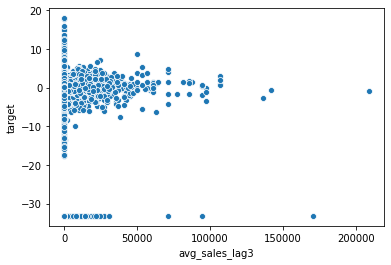

In [ ]:
sns.scatterplot(x='avg_sales_lag3', y='target', data=train_aggregated_measures)
plt.show()

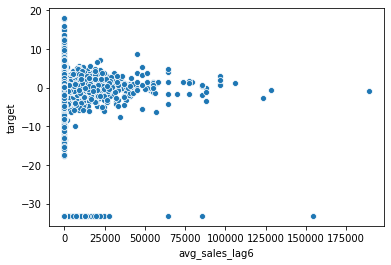

In [ ]:
sns.scatterplot(x='avg_sales_lag6', y='target', data=train_aggregated_measures)
plt.show()

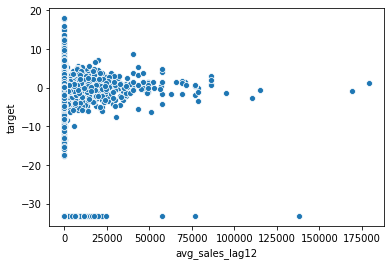

In [ ]:
sns.scatterplot(x='avg_sales_lag12', y='target', data=train_aggregated_measures)
plt.show()

One more thing that we can observe here is that for our rare data points(loyalty score <-30) we can see that most of these have an avg_sales_lag12 <= 2500.

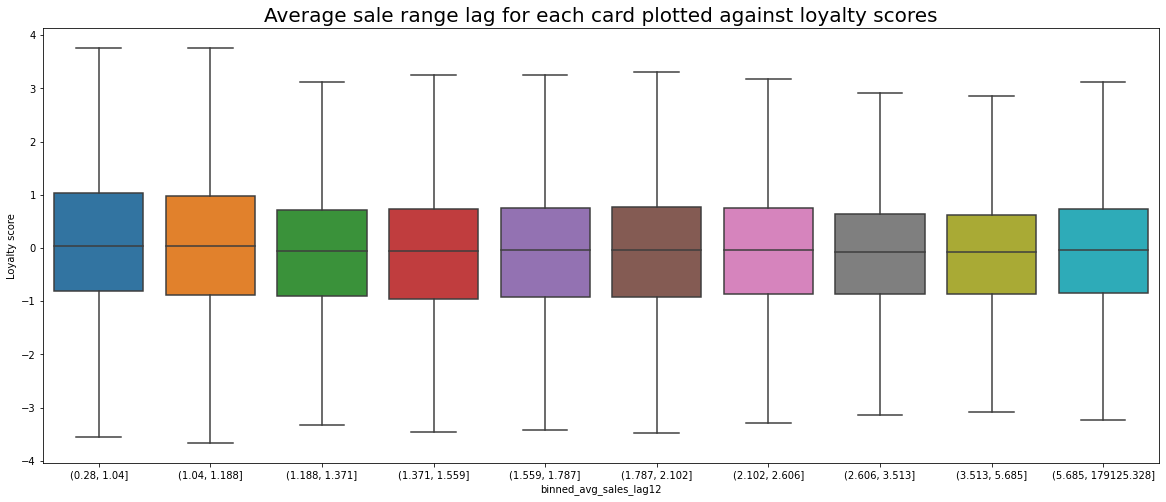

In [ ]:
bins = np.percentile(train_aggregated_measures["avg_sales_lag12"], range(0,101,10))
train_aggregated_measures['binned_avg_sales_lag12'] = pd.cut(train_aggregated_measures['avg_sales_lag12'], bins)

plt.figure(figsize=(20,8))
sns.boxplot(x="binned_avg_sales_lag12", y=train_aggregated_measures['target'], data=train_aggregated_measures, showfliers=False)
#plt.xticks(rotation='vertical')
plt.xlabel('binned_avg_sales_lag12')
plt.ylabel('Loyalty score')
plt.title("Average sale range lag for each card plotted against loyalty scores", fontsize = 20)
plt.show()

As we can see there is a lot of variance here and this can be very useful as a feature to predict loyalty scores.

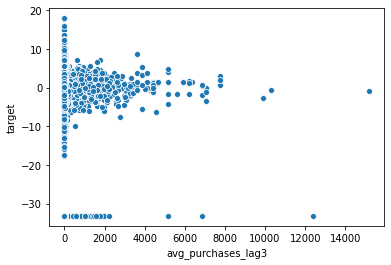

In [ ]:
sns.scatterplot(x='avg_purchases_lag3', y='target', data=train_aggregated_measures)
plt.show()

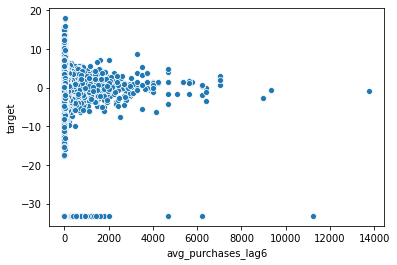

In [ ]:
sns.scatterplot(x='avg_purchases_lag6', y='target', data=train_aggregated_measures)
plt.show()

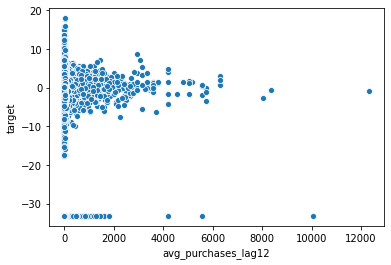

In [ ]:
sns.scatterplot(x='avg_purchases_lag12', y='target', data=train_aggregated_measures)
plt.show()

The same observation that for our rare data points(loyalty scores<=-30) the purchase range lag is less than 2000.
<br>
This can be a very useful feature as well for predicting the loyalty scores.

# To Summarize:

1. The target variable(Loyalty score) has 1% of its points that seem like outliers. Dealing with these points depends on the number of these points in the test data. In that case, these arent actually outliers. They can be termed as Rare data points. However, these points would be difficult to predict and could have a major impact on our final scores.
2. The first active month in train file could be very useful.
3. Aggregated transaction features for each card would be very helpful in predicting the loyalty score using the regression models. Most of our features would be from this file.
4. Some features can be used from the merchants file as well. For eg, we can have a categorical variable that states if the transaction involved a merchant that was active in the last 3/6 or 12 months. The average purchases and sales ranges might be useful as well.